In [ ]:
!pip install rouge_score datasets faiss-cpu bert_score

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nv

In [ ]:
# Importing all the required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import (Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM, AutoTokenizer,
                          AutoModelForSequenceClassification, AutoConfig, set_seed, DPRContextEncoder, DPRContextEncoderTokenizer,
                          RagRetriever, RagTokenizer, RagTokenForGeneration, T5Config, T5ForConditionalGeneration, T5Tokenizer)
from transformers.modeling_utils import PreTrainedModel
from rouge_score import rouge_scorer
from bert_score import score as bert_score
from datasets import load_dataset, DatasetDict, load_from_disk
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import logging
import faiss
import os

In [ ]:
# Setup logging and tensorboard writer
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
writer = SummaryWriter(log_dir='./tensorboard_logs')

# Checking if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the dataset
dataset = load_dataset("cnn_dailymail", "3.0.0")

# Reducing the dataset size for initial testing (Using the first 100 examples)
small_train_data = dataset["train"].select(range(100))
small_val_data = dataset["validation"].select(range(100))
small_test_data = dataset["test"].select(range(100))

# Loading a pre-trained NLI model for factual consistency checking
nli_tokenizer = AutoTokenizer.from_pretrained("roberta-large-mnli")
nli_model = AutoModelForSequenceClassification.from_pretrained("roberta-large-mnli").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
def preprocess_function(examples, tokenizer):
    # Extracting the input text (articles) and target text (highlights) from the dataset
    inputs = examples['article']
    targets = examples['highlights']

    # Tokenizing the input articles. This converts the text into token IDs that the model can understand.
    # The 'max_length' parameter ensures that the tokenized input does not exceed the specified length (512 tokens in this case).
    # The 'truncation=True' parameter ensures that if the input exceeds the max length, it will be truncated to fit.
    model_inputs = tokenizer(inputs, max_length=512, truncation=True)

    # Tokenizing the target highlights in the same way. This will also generate token IDs for the target text.
    # Again, the 'max_length' is set to 128 tokens for the targets, and 'truncation=True' will truncate if necessary.
    labels = tokenizer(text_target=targets, max_length=128, truncation=True)

    # Assigning the tokenized target (label) input IDs to the 'labels' key in the model_inputs dictionary.
    # These labels will be used during training to calculate the loss and optimise the model.
    model_inputs['labels'] = labels['input_ids']

    # Returning the processed model inputs, which include both the tokenized inputs and labels.
    return model_inputs

In [ ]:
# Dual-pass generation function
def dual_pass_generation(input_text, t5_model, nli_model, t5_tokenizer, nli_tokenizer, device):
    # First pass: Generating an initial summary using the T5 model.
    # Constructing the prompt by adding the "summarise:" prefix to the input text.
    prompt_text = "summarise: " + input_text

    # Tokenizing the input text. This converts the text into token IDs that the model can understand.
    # The tokenization process also pads the input to a fixed length (max_length=512) and truncates if necessary.
    # The result is then moved to the specified device (GPU or CPU).
    t5_inputs = t5_tokenizer(prompt_text, return_tensors="pt", max_length=512, truncation=True, padding="max_length").to(device)

    # Generation parameters:
    # - max_length=150: The maximum length of the generated summary.
    # - min_length=50: The minimum length of the generated summary.
    # - num_beams=4: Beam search is used to generate more diverse outputs (4 beams).
    # - early_stopping=True: The generation stops early when all beams reach the end of the sequence.
    with torch.no_grad():
        t5_outputs = t5_model.generate(
            t5_inputs["input_ids"],
            attention_mask=t5_inputs["attention_mask"],
            max_length=150,
            min_length=50,
            num_beams=4,
            early_stopping=True
        )

    # Decoding the generated token IDs back into a string of text (the initial summary).
    # Skipping the special tokens to return only the human-readable summary.
    first_pass_output = t5_tokenizer.decode(t5_outputs[0], skip_special_tokens=True)

    # Second pass: Checking the initial summary for contradictions using the NLI model.
    # The NLI model takes the generated summary (first_pass_output) and the original input text to detect if there are any contradictions between the two.
    # Both texts are tokenized, padded, and truncated similarly to the first pass.
    nli_inputs = nli_tokenizer(first_pass_output, input_text, return_tensors="pt", max_length=512, truncation=True, padding="max_length").to(device)
    nli_outputs = nli_model(**nli_inputs)

    # Calculating the contradiction score using the softmax output of the NLI model.
    # The score represents the probability that a contradiction exists between the generated summary and the input text.
    contradiction_score = torch.softmax(nli_outputs.logits, dim=-1)[0][0].item()

    # If the contradiction score is higher than 0.5 (indicating a strong likelihood of contradiction),
    # the summary is refined by passing it back through the T5 model with a new prompt.
    if contradiction_score > 0.5:
        # Creating a new prompt using "Role Prompting" which instructs the T5 model to correct any factual errors in the initial summary.
        refined_prompt = f"You are an expert at summarising contents, correct any factual errors: {first_pass_output}"

        # Tokenizing the new prompt and generate a refined summary using the T5 model.
        # The same generation parameters are used as in the first pass.
        t5_inputs = t5_tokenizer(refined_prompt, return_tensors="pt", max_length=512, truncation=True, padding="max_length").to(device)

        with torch.no_grad():
            t5_outputs = t5_model.generate(
                t5_inputs["input_ids"],
                attention_mask=t5_inputs["attention_mask"],
                max_length=150,
                min_length=50,
                num_beams=4,
                early_stopping=True
            )

        # Decoding the refined summary and returning it, along with a flag indicating that refinement occurred.
        refined_summary = t5_tokenizer.decode(t5_outputs[0], skip_special_tokens=True)
        return refined_summary, True  # Indicates the summary was refined

    # If no contradiction was detected, return the initial summary and a flag indicating that no refinement was needed.
    return first_pass_output, False  # No refinement was needed

In [ ]:
# Calculating semantic accuracy using BERTScore, comparing model predictions against references.
def calculate_semantic_accuracy(predictions, references, model_type='roberta-large-mnli'):
    P, R, F1 = bert_score(predictions, references, model_type=model_type, verbose=False)
    # Defining a threshold for considering a prediction as 'accurate'
    threshold = 0.7
    # Calculating the percentage of predictions that meet the accuracy threshold
    accurate_predictions = (F1 >= threshold).float().mean().item()
    return accurate_predictions

In [ ]:
# Evaluation function with hallucination detection
def evaluate_model_with_hallucination(t5_model, dataset, t5_tokenizer, nli_model, nli_tokenizer, device, num_samples=3):
    # Initialising lists to store predictions and reference summaries
    predictions = []
    references = []

    # Looping over each example in the dataset
    for example in dataset:
        # Extracting the input article and the reference summary (highlights)
        input_text = example["article"]
        reference_text = example["highlights"]

        # Generating a summary for the input article using the dual-pass generation function
        prediction_text, _ = dual_pass_generation(input_text, t5_model, nli_model, t5_tokenizer, nli_tokenizer, device)

        # Checking if the generated summary is empty; if so, replace it with a placeholder
        if not prediction_text.strip():
            prediction_text = "No summary generated."

        # Appending the generated summary and reference summary to their respective lists
        predictions.append(prediction_text)
        references.append(reference_text)

    # Calculating the semantic accuracy using BERTScore, which compares the generated summaries against the references
    # This accuracy is used to estimate how semantically close the generated summaries are to the reference summaries
    accuracy = calculate_semantic_accuracy(predictions, references, model_type='roberta-large-mnli')

    # The hallucination rate is defined as the complement of the accuracy (i.e., 1 - accuracy)
    # It represents the proportion of summaries that contain factual inaccuracies
    hallucination_rate = 1 - accuracy

    # Initialising a ROUGE scorer to calculate ROUGE-1 and ROUGE-L scores for the generated summaries
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

    # Calculating ROUGE scores for each pair of reference and generated summary
    rouge_scores = [scorer.score(ref, pred) for ref, pred in zip(references, predictions)]

    # Computing the average ROUGE-1 and ROUGE-L scores across all examples
    rouge1 = sum(score['rouge1'].fmeasure for score in rouge_scores) / len(rouge_scores)
    rougeL = sum(score['rougeL'].fmeasure for score in rouge_scores) / len(rouge_scores)

    # Printing a few sample outputs for manual inspection
    print("Sample Outputs for Manual Inspection:")
    for i in range(min(num_samples, len(predictions))):
        print(f"Input: {dataset[i]['article']}")
        print(f"Reference: {dataset[i]['highlights']}")
        print(f"Prediction: {predictions[i]}")
        print("\n")

    # Returning the calculated metrics: ROUGE-1, ROUGE-L, accuracy, and hallucination rate
    return rouge1, rougeL, accuracy, hallucination_rate

In [ ]:
# Ensuring reproducibility
set_seed(42)

# Initialising the T5 model and tokenizer
t5_model = T5ForConditionalGeneration.from_pretrained('t5-base').to(device)
t5_tokenizer = T5Tokenizer.from_pretrained('t5-base')

# Initialising NLI model (for contradiction detection)
nli_tokenizer = AutoTokenizer.from_pretrained("roberta-large-mnli")
nli_model = AutoModelForSequenceClassification.from_pretrained("roberta-large-mnli").to(device)

# Function to clone shared weights for memory efficiency
def clone_shared_weights(model):
    if hasattr(model, 'model') and hasattr(model.model, 'shared'):
        cloned_weight = model.model.shared.weight.detach().clone().requires_grad_(True)
        model.model.shared.weight = cloned_weight
        model.model.encoder.embed_tokens.weight = cloned_weight
        model.model.decoder.embed_tokens.weight = cloned_weight
        model.model.lm_head.weight = cloned_weight

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPre

In [ ]:
def train_and_evaluate_baseline_model(t5_model, t5_tokenizer, dataset, device):

    clone_shared_weights(t5_model)  # Ensuring the T5 model weights are weights cloned

    # Initialising lists to hold training / validation loss data
    train_losses = []
    val_losses = []

    # Defining preprocessing with the correct tokenizer pass
    preprocess_with_tokenizer = lambda x: preprocess_function(x, t5_tokenizer)    # Preprocess data
    tokenized_data = {
        "train": small_train_data.map(preprocess_with_tokenizer, batched=True),
        "val": small_val_data.map(preprocess_with_tokenizer, batched=True),
        "test": small_test_data.map(preprocess_with_tokenizer, batched=True)
    }

    # Defining training arguments
    training_args = Seq2SeqTrainingArguments(
        output_dir=f"./results_t5_baseline",
        eval_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        num_train_epochs=5,
        weight_decay=0.01,
        fp16=True,
        logging_dir='./logs',
        logging_steps=10,
    )

    # Initialising and running the trainer
    trainer = Seq2SeqTrainer(
        model=t5_model,
        args=training_args,
        train_dataset=tokenized_data['train'],
        eval_dataset=tokenized_data['val'],
        data_collator=DataCollatorForSeq2Seq(t5_tokenizer, model=t5_model),
        tokenizer=t5_tokenizer,
    )
    torch.cuda.empty_cache()
    trainer.train()

    # Collecting and resetting training / validation loss data within the training loop
    for log in trainer.state.log_history:
        if 'loss' in log:
            train_losses.append(log['loss'])
        if 'eval_loss' in log:
            val_losses.append(log['eval_loss'])

    # Evaluate the model
    rouge1, rougeL, accuracy, hallucination_rate = evaluate_model_with_hallucination(t5_model, tokenized_data['test'], t5_tokenizer, nli_model, nli_tokenizer, device)

    # Return the evaluation metrics only
    return {
        "rouge1": rouge1,
        "rougeL": rougeL,
        "accuracy": accuracy,
        "hallucination_rate": hallucination_rate
    }

    # Saving the trained model and tokenizer
    t5_model.save_pretrained(f"./saved_models/t5-baseline")
    t5_tokenizer.save_pretrained(f"./saved_models/t5-baseline-tokenizer")
    torch.cuda.empty_cache()  # Clearing the GPU cache

baseline_results = train_and_evaluate_baseline_model(t5_model, t5_tokenizer, dataset, device)

print(baseline_results)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,1.812600,1.893883
2,1.553100,1.886683
3,1.687600,1.893427
4,1.541800,1.898768
5,1.802700,1.902998


Sample Outputs for Manual Inspection:
Input: (CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States, neither of which is an ICC member, opposed the Palestinians' efforts to join the body. But Palestinian Foreign Minister Riad a

In [ ]:
baseline_results

{'rouge1': 0.34603017269471703,
 'rougeL': 0.25573318354588603,
 'accuracy': 0.921999990940094,
 'hallucination_rate': 0.078000009059906}

In [ ]:
# Initialising the context encoder and tokenizer
ctx_encoder = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base').to(device)
ctx_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

# Function to generate embeddings
def generate_embeddings(batch):
    inputs = ctx_tokenizer(batch['article'], return_tensors='pt', truncation=True, padding='max_length', max_length=512).to(device)
    with torch.no_grad():
        embeddings = ctx_encoder(**inputs).pooler_output.cpu().numpy()
    return {'embeddings': embeddings}

config.json:   0%|          | 0.00/492 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.


In [ ]:
# Applying the embeddings generation function to the dataset in chunks
small_train_data = small_train_data.map(generate_embeddings, batched=True, batch_size=1)
small_val_data = small_val_data.map(generate_embeddings, batched=True, batch_size=1)
small_test_data = small_test_data.map(generate_embeddings, batched=True, batch_size=1)

# Function to retrieve documents using in-memory similarity search
def retrieve_documents(query_embedding, doc_embeddings, k=3):
    similarities = cosine_similarity(query_embedding, doc_embeddings)
    top_k_indices = np.argsort(similarities, axis=1)[:, -k:]
    return top_k_indices

# Preprocessing data with tokenization and document retrieval
def preprocess_function_with_retrieval(examples, tokenizer, doc_embeddings, k=3):
    inputs = examples["article"]
    # Getting the embeddings from DPRContextEncoder
    query_embedding = ctx_encoder(**ctx_tokenizer(inputs, return_tensors='pt', truncation=True, padding='max_length', max_length=512).to(device)).pooler_output
    query_embedding = query_embedding.detach().cpu().numpy()

    top_k_indices = retrieve_documents(query_embedding, doc_embeddings, k=k)

    # Ensuring indices are within bounds
    retrieved_docs = [" ".join([examples['article'][i] for i in indices if i < len(examples['article'])]) for indices in top_k_indices]

    inputs_with_docs = [f"{inp} {doc}" for inp, doc in zip(inputs, retrieved_docs)]

    model_inputs = tokenizer(inputs_with_docs, max_length=512, truncation=True, padding='max_length')
    labels = tokenizer(text_target=examples["highlights"], max_length=128, truncation=True, padding='max_length')
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Generating tokenized data with document retrieval in smaller batches to save memory
doc_embeddings = np.vstack(small_train_data['embeddings'])
tokenized_data = {
    "train": small_train_data.map(lambda x: preprocess_function_with_retrieval(x, t5_tokenizer, doc_embeddings), batched=True, batch_size=1),
    "val": small_val_data.map(lambda x: preprocess_function_with_retrieval(x, t5_tokenizer, doc_embeddings), batched=True, batch_size=1),
    "test": small_test_data.map(lambda x: preprocess_function_with_retrieval(x, t5_tokenizer, doc_embeddings), batched=True, batch_size=1)
}

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [ ]:
# Training and evaluating T5 model with retrieval
def train_and_evaluate_ras_model(t5_model, t5_tokenizer, dataset, device):

    # Cloning shared weights if needed
    clone_shared_weights(t5_model)

    # Initialising lists to hold training / validation loss data
    train_losses = []
    val_losses = []

    # Defining training arguments with gradient accumulation for better memory management
    training_args = Seq2SeqTrainingArguments(
        output_dir="./results_t5_ras",
        eval_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        num_train_epochs=5,
        weight_decay=0.01,
        fp16=True,  # Mixed precision training
        logging_dir='./logs',
        logging_steps=10,
    )

    # Initialising the Seq2Seq trainer
    trainer = Seq2SeqTrainer(
        model=t5_model,
        args=training_args,
        train_dataset=tokenized_data['train'],
        eval_dataset=tokenized_data['val'],
        data_collator=DataCollatorForSeq2Seq(t5_tokenizer, model=t5_model),
        tokenizer=t5_tokenizer,
    )
    torch.cuda.empty_cache()  # Clearing the GPU cache

    # Training the model
    trainer.train()

    # Collecting and resetting loss data within the training loop
    for log in trainer.state.log_history:
        if 'loss' in log:
            train_losses.append(log['loss'])
        if 'eval_loss' in log:
            val_losses.append(log['eval_loss'])

    # Evaluating the model
    rouge1, rougeL, accuracy, hallucination_rate = evaluate_model_with_hallucination(t5_model, tokenized_data['test'], t5_tokenizer, nli_model, nli_tokenizer, device)

    # Returning the evaluation metrics only
    return {
        "rouge1": rouge1,
        "rougeL": rougeL,
        "accuracy": accuracy,
        "hallucination_rate": hallucination_rate
    }

    # Saving the trained model and tokenizer
    t5_model.save_pretrained("./saved_models/t5-ras")
    t5_tokenizer.save_pretrained("./saved_models/t5-ras-tokenizer")

    torch.cuda.empty_cache()  # Clearing the GPU cache

# Training and evaluating the enhanced T5 model with RAS
ras_results = train_and_evaluate_ras_model(t5_model, t5_tokenizer, dataset, device)

# Printing the evaluation metrics for RAS
print(ras_results)

Epoch,Training Loss,Validation Loss
1,0.502200,0.773543
2,0.468400,0.776640
3,0.594800,0.781296
4,0.479600,0.783083
5,0.483700,0.783603


Sample Outputs for Manual Inspection:
Input: (CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States, neither of which is an ICC member, opposed the Palestinians' efforts to join the body. But Palestinian Foreign Minister Riad a

In [ ]:
ras_results

{'rouge1': 0.3696867497989071,
 'rougeL': 0.2736208725999927,
 'accuracy': 0.9599999785423279,
 'hallucination_rate': 0.04000002145767212}

In [ ]:
# Creating a DataFrame to store the results
results_df = pd.DataFrame({
    "Metric": ["rouge1", "rougeL", "accuracy", "hallucination_rate"],
    "Baseline": [
        baseline_results["rouge1"],
        baseline_results["rougeL"],
        baseline_results["accuracy"],
        baseline_results["hallucination_rate"]
    ],
    "RAS": [
        ras_results["rouge1"],
        ras_results["rougeL"],
        ras_results["accuracy"],
        ras_results["hallucination_rate"]
    ]
})

# Displaying the DataFrame
results_df

,Metric,Baseline,RAS
0,rouge1,0.346030,0.369687
1,rougeL,0.255733,0.273621
2,accuracy,0.922000,0.960000
3,hallucination_rate,0.078000,0.040000


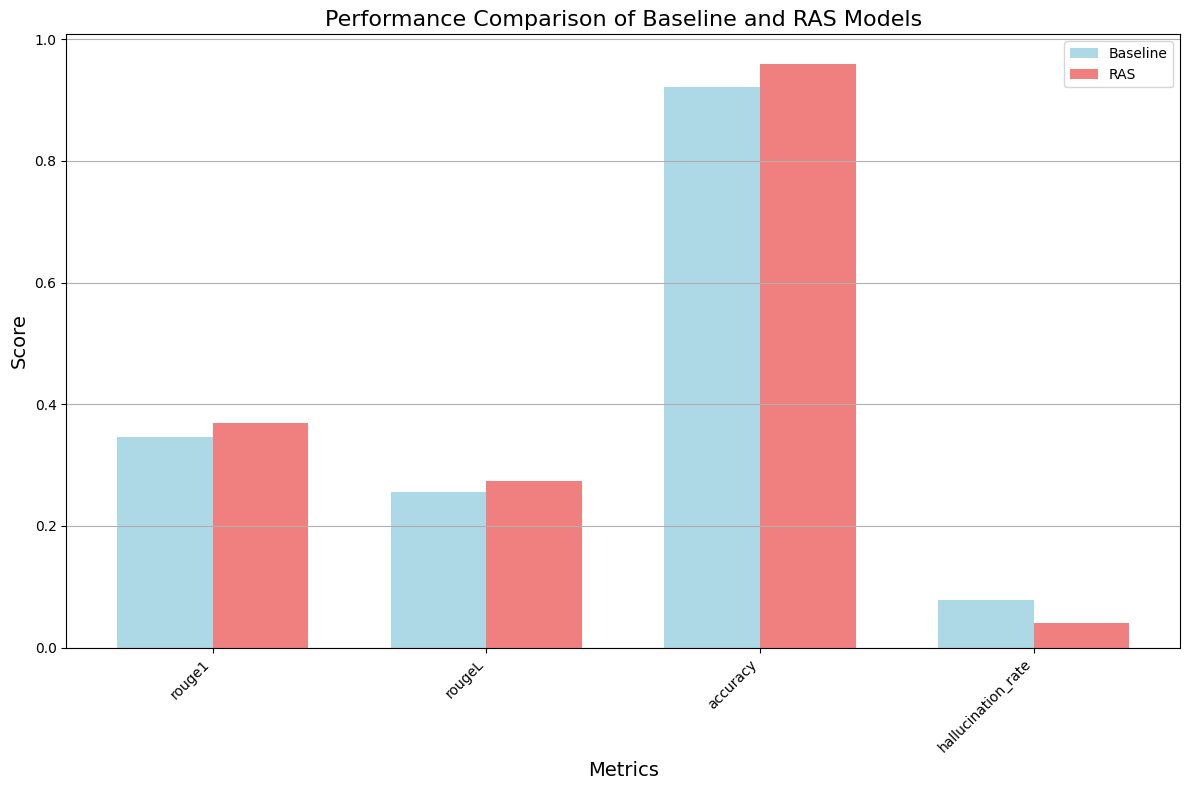

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define the position of the bars on the x-axis
n_metrics = len(results_df)  # Number of metrics (rows in DataFrame)
bar_width = 0.35
x = np.arange(n_metrics)  # the label locations

# Define colors for the models
colors = ['lightblue', 'lightcoral']

# Create the figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Plotting each model with specified colors
ax.bar(x - bar_width/2, results_df['Baseline'], bar_width, label='Baseline', color=colors[0])
ax.bar(x + bar_width/2, results_df['RAS'], bar_width, label='RAS', color=colors[1])

# Adding titles and labels
ax.set_xlabel('Metrics', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Performance Comparison of Baseline and RAS Models', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(results_df['Metric'], rotation=45, ha="right")

ax.legend()

# Adding gridlines for better readability
ax.yaxis.grid(True)

# Tight layout for better spacing
plt.tight_layout()

# Save the plot as a high-resolution PNG file
plt.savefig('model_comparison_grouped.png', dpi=300)

# Show the plot
plt.show()

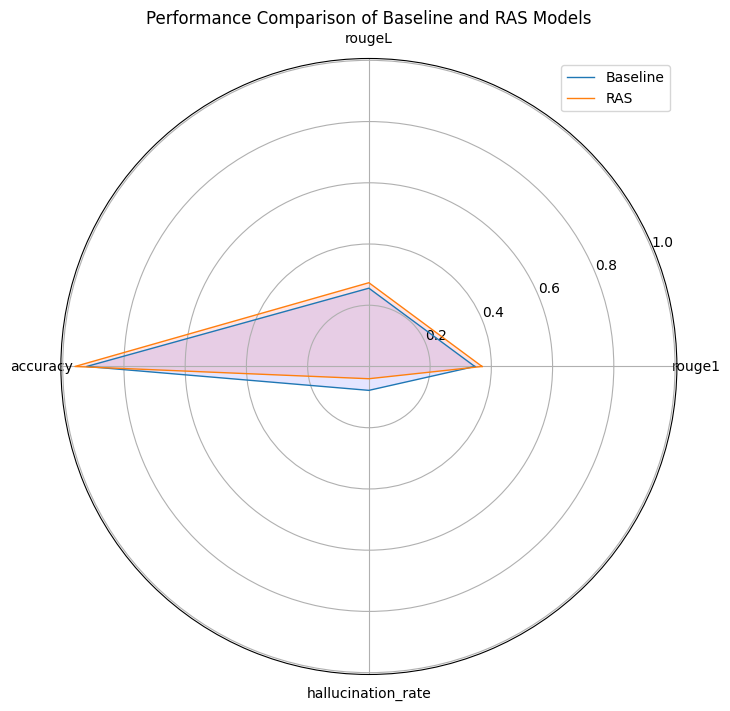

In [ ]:
import matplotlib.pyplot as plt
from math import pi

# Extract categories and prepare data
categories = results_df["Metric"].tolist()  # List of metrics
N = len(categories)

# Values for the Baseline model
values_baseline = results_df["Baseline"].values.flatten().tolist()
values_baseline += values_baseline[:1]

# Values for the RAS model
values_ras = results_df["RAS"].values.flatten().tolist()
values_ras += values_ras[:1]

# Angles for the radar chart
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Plotting the radar chart
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# Draw one axis per variable and add labels
plt.xticks(angles[:-1], categories)

# Plot and fill for the Baseline model
ax.plot(angles, values_baseline, linewidth=1, linestyle='solid', label='Baseline')
ax.fill(angles, values_baseline, 'b', alpha=0.1)

# Plot and fill for the RAS model
ax.plot(angles, values_ras, linewidth=1, linestyle='solid', label='RAS')
ax.fill(angles, values_ras, 'r', alpha=0.1)

# Add title and legend
plt.legend(loc='upper right')
plt.title('Performance Comparison of Baseline and RAS Models')
plt.savefig('spiderplot_performance.png', dpi=300)
plt.show()
